In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from filters.lee import lee_filter

### to change according to your machine
base_dir = os.path.expanduser(r'E:\Competition\tianchi\lcz-master\dataset\\')
path_training = os.path.join(base_dir, 'training.h5')
path_validation = os.path.join(base_dir, 'validation.h5')

fid_training = h5py.File(path_training,'r')
fid_validation = h5py.File(path_validation,'r')

## we can have a look at which keys are stored in the file
## you will get the return [u'label', u'sen1', u'sen2']
## sen1 and sen2 means the satellite images
#print fid_training.keys()
print (fid_validation.keys())

### get s1 image channel data
### it is not really loaded into memory. only the indexes have been loaded.
print ("-" * 60)
print ("training part")
s1_training = fid_training['sen1']
print (s1_training.shape)
s2_training = fid_training['sen2']
print (s2_training.shape)
label_training = fid_training['label']
print (label_training.shape)

print ("-" * 60)
print ("validation part")
s1_validation = fid_validation['sen1']
print (s1_validation.shape)
s2_validation = fid_validation['sen2']
print (s2_validation.shape)
label_validation = fid_validation['label']
print (label_validation.shape)

KeysView(<HDF5 file "validation.h5" (mode r)>)
------------------------------------------------------------
training part
(352366, 32, 32, 8)
(352366, 32, 32, 10)
(352366, 17)
------------------------------------------------------------
validation part
(24119, 32, 32, 8)
(24119, 32, 32, 10)
(24119, 17)


In [3]:
'''s1=[]
s2=[]
for i in range(17):
    idx=np.where(label_validation[:,i])[0][:500]
    s1.append(s1_validation[list(idx)])
    s2.append(s2_validation[list(idx)])
s1=np.concatenate(s1)
s2=np.concatenate(s2)
print(s1.shape)'''
print(s1_training.shape)
s1 = s1_training[:20000,...]
s2 = s2_training[:20000,...]
del s1_training, s2_training
# lee filter
'''
for i in range(s1.shape[0]):
    for j in range(8):
        s1[i,:,:,j] = lee_filter(s1[i,:,:,j],win_size=5,cu=0.25)
        s2[i,:,:,j] = lee_filter(s2[i,:,:,j],win_size=5,cu=0.25)
'''
# s1 processing
for i in range(8):
    if i % 2 != 0:
        continue
    locals()['s1_'+str(i)] =  np.sqrt(np.square(s1[:,:,:,i])+np.square(s1[:,:,:,i+1]))
    #振幅值取log
    locals()['s1_'+str(i)] = np.log10(locals()['s1_'+str(i)]+0.0000001)
    locals()['s1_'+str(i+1)] =  np.arctan2(s1[:,:,:,i+1],s1[:,:,:,i])

s1_energy = np.zeros(s1.shape)
for i in range(8):
    s1_energy[:,:,:,i] = locals()['s1_'+str(i)]

for i in range(s1.shape[0]):
    for j in range(8):
        if j % 2 == 0:
            #幅度归一化
            s1_energy[i,:,:,j] -= np.mean(s1_energy[i,:,:,j],axis=0)
            s1_energy[i,:,:,j] /= np.std(s1_energy[i,:,:,j],axis=0)+0.0000001
            s1_energy[i,:,:,j] = (s1_energy[i,:,:,j] - s1_energy[i,:,:,j].min()) / (s1_energy[i,:,:,j].max() - s1_energy[i,:,:,j].min())
        else:
            #相位归一化
            s1_energy[i,:,:,j] = (s1_energy[i,:,:,j] + np.pi) / (2*np.pi)
print(s1_energy[i,:,:,0].mean(),s1_energy[i,:,:,0].std(), s1_energy[i,:,:,0].max(), s1_energy[i,:,:,0].min())

# s2 processing
#取log, 归一化
for i in range(s2.shape[0]):
    for j in range(10):
        s2[i,:,:,j] = np.log10(s2[i,:,:,j]+0.0000001)
        s2[i,:,:,j] -= np.mean(s2[i,:,:,j],axis=0)
        s2[i,:,:,j] /= np.std(s2[i,:,:,j],axis=0)+0.0000001
        s2[i,:,:,j] = (s2[i,:,:,j] - s2[i,:,:,j].min()) / (s2[i,:,:,j].max() - s2[i,:,:,j].min())
print(s2[i,:,:,0].mean(),s2[i,:,:,0].std(),s2[i,:,:,0].max(),s2[i,:,:,0].min())


(352366, 32, 32, 8)
0.6144211354549449 0.16171332383226253 1.0 0.0


c:\users\sycdf\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


0.35654458865287164 0.16972412248611696 1.0 0.0


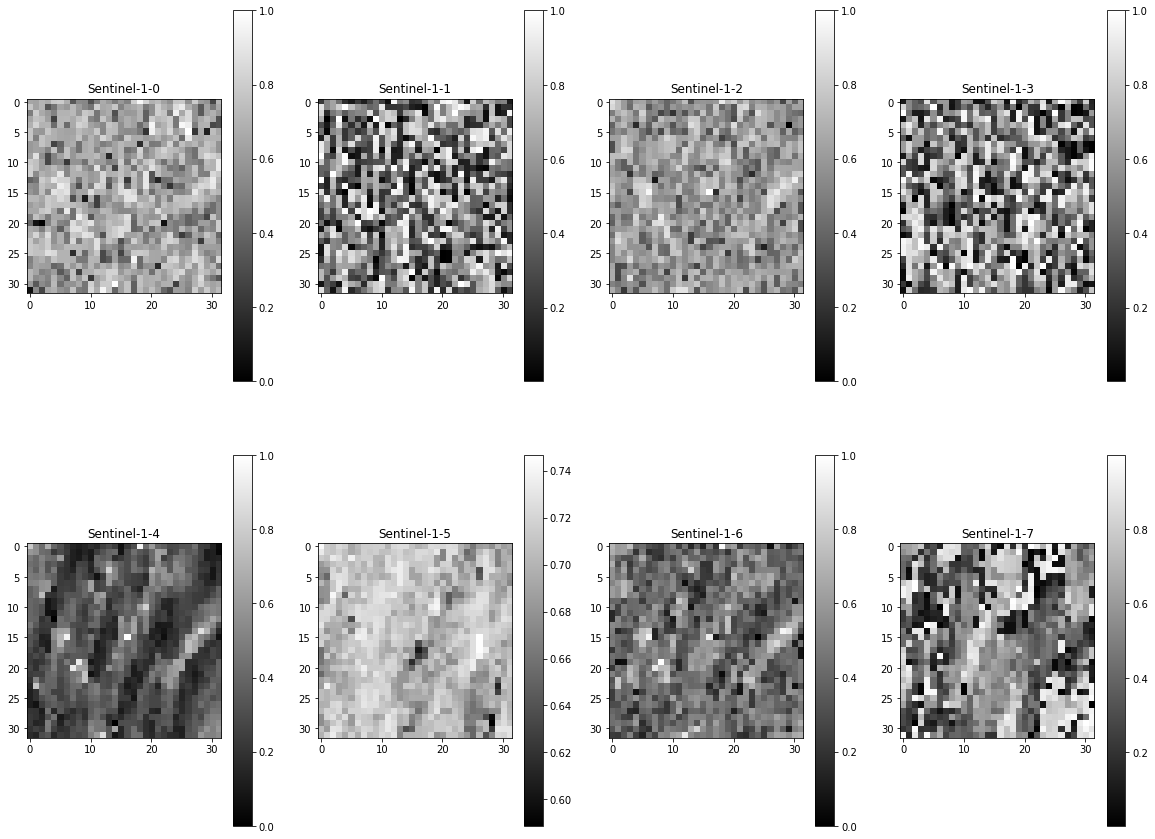

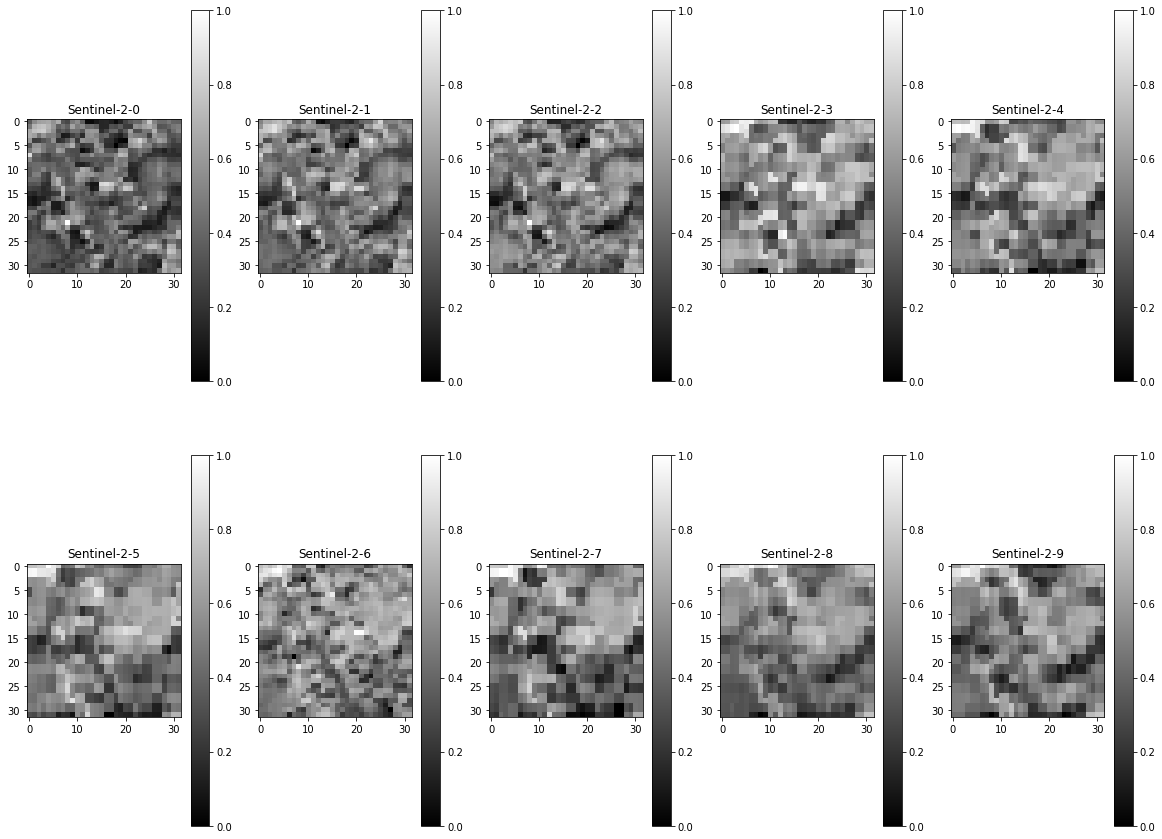

In [3]:
plt.subplots(figsize=(20, 15))
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(s1_energy[0,:,:,i],cmap=plt.cm.get_cmap('gray'));
  plt.colorbar()
  plt.title('Sentinel-1-%d'%(i))
plt.show()

plt.subplots(figsize=(20, 15))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(s2[0,:,:,i],cmap=plt.cm.get_cmap('gray'));
  plt.colorbar()
  plt.title('Sentinel-2-%d'%(i))
plt.show()

In [4]:
f = h5py.File('training_preprc.h5','w')
f.create_dataset('s1',data=s1_energy)
f.create_dataset('s2',data=s2)
f.close()